In [1]:
import os
import csv

# Image path
image_folder = "/local/data1/honzh073/data/8bit_downsample"

# CSV path
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/image_data.csv"

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Create a CSV writer object and write the header
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through files in the folder
    for filename in sorted(os.listdir(image_folder)):
        # Construct the complete image file path
        image_path = os.path.join(image_folder, filename)

        # Parse the filename to extract HospitalID, PatientID, image number, and image label
        parts = filename.split('_')
        hospital_id = parts[3]
        patient_id = parts[1]
        image_number = parts[6]
        image_label = parts[4]

        # Write data into the CSV file
        writer.writerow({
            'HospitalID': hospital_id,
            'PatientID': patient_id,
            'ImageID': image_number,
            'ImagePath': image_path,
            'Label': image_label
        })

# Print a message indicating that the CSV file has been created and saved
print("CSV file has been created and saved to:", csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/image_data.csv


In [2]:
import csv
from collections import defaultdict
import random

# 读取原始CSV文件
input_csv_path = "/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/image_data.csv"

# 用于存储按照患者ID分组的图片信息
patient_data = defaultdict(list)

# 读取CSV文件并按照患者ID进行分组
with open(input_csv_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        patient_id = row['PatientID']
        patient_data[patient_id].append(row)

# 计算患者ID的数量
num_patients = len(patient_data)

# 计算划分的数量
num_train = int(num_patients * 0.8)
num_val = int(num_patients * 0.1)
num_test = num_patients - num_train - num_val

# 获取随机选择的患者ID
all_patient_ids = list(patient_data.keys())
random.shuffle(all_patient_ids)

# 划分数据集
train_patients = all_patient_ids[:num_train]
val_patients = all_patient_ids[num_train:num_train + num_val]
test_patients = all_patient_ids[num_train + num_val:]

# 用于存储划分后的数据
train_data = []
val_data = []
test_data = []

# 遍历按照患者ID分组的数据，并将数据划分到对应的数据集中
for patient_id, images in patient_data.items():
    if patient_id in train_patients:
        train_data.extend(images)
    elif patient_id in val_patients:
        val_data.extend(images)
    elif patient_id in test_patients:
        test_data.extend(images)

# 将数据集写入CSV文件
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=images[0].keys())
        writer.writeheader()
        writer.writerows(data)

write_to_csv('/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/train.csv', train_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/val.csv', val_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/test.csv', test_data)

print("训练数据、验证数据和测试数据已经生成并保存到 train.csv, val.csv 和 test.csv。")


训练数据、验证数据和测试数据已经生成并保存到 train.csv, val.csv 和 test.csv。


In [3]:
import torch
from torchvision import transforms
import csv
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
import shutil
from sklearn.metrics import roc_curve, roc_auc_score

#  def split_by_patient(dataset_root, target_root, train_ratio, val_ratio):
#     if not os.path.exists(target_root):
#         # create target root if not exit
#         os.makedirs(target_root)

#         # AFF and NFF folder
#         fracture_types = ['0_NFF', '1_AFF']

#         for fracture_type in fracture_types:
#             source_folder = os.path.join(dataset_root, fracture_type)
#             patients = os.listdir(source_folder)
            
#             # select random patients
#             random.seed(123)
#             random.shuffle(patients)
            
#             # split patients
#             total_patients = len(patients)
#             train_end = int(total_patients * train_ratio)
#             val_end = train_end + int(total_patients * val_ratio)
            
#             train_patients = patients[:train_end]
#             val_patients = patients[train_end:val_end]
#             test_patients = patients[val_end:]
            
#             # copy images to folder
#             for patient_id in train_patients:
#                 source_path = os.path.join(source_folder, patient_id)
#                 target_path = os.path.join(target_root, 'train', fracture_type, patient_id)
#                 shutil.copytree(source_path, target_path)
            
#             for patient_id in val_patients:
#                 source_path = os.path.join(source_folder, patient_id)
#                 target_path = os.path.join(target_root, 'val', fracture_type, patient_id)
#                 shutil.copytree(source_path, target_path)
            
#             for patient_id in test_patients:
#                 source_path = os.path.join(source_folder, patient_id)
#                 target_path = os.path.join(target_root, 'test', fracture_type, patient_id)
#                 shutil.copytree(source_path, target_path)
#         print("Dataset split completed.")
    
#     else:
#         print("Target dataset folder already exists.")

from torchvision.datasets import ImageFolder
from torchvision import transforms
import csv

def create_dataset(train_root, val_root, test_root, train_csv, val_csv, test_csv):
    # Define data augmentation transforms for training data
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),
        transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Define transform for validation and test data
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Read CSV files and create datasets
    train_dataset = CustomDataset(train_csv, root=train_root, transform=train_transform)
    val_dataset = CustomDataset(val_csv, root=val_root, transform=test_transform)
    test_dataset = CustomDataset(test_csv, root=test_root, transform=test_transform)

    return train_dataset, val_dataset, test_dataset

class CustomDataset(ImageFolder):
    def __init__(self, csv_file, root, transform=None):
        self.data = []
        self.transform = transform

        # Read CSV file
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = os.path.join(root, row['ImagePath'])
                label = row['Label']
                # If Label is 'NFF', define as 0; If Label is 'AFF', define as 1
                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def show_image(dataset, num_images=5):
    # Get some random indices from the dataset
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        plt.axis('off')
    plt.show()

def get_classweight(train_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # aff and nff numbers in training dataset
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff]   
    
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name, device):

    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    if model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")


    # Freeze layers except the last
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True
   
   
    # Modify the output layer
    num_classes = 2
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    else:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    # Move model to the specified device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Training (loss and accuracy)
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {loss.item():.4f}, "
            f"Validation Loss: {validation_loss:.4f}, "
            f"Train Acc: {train_accuracy:.2f}%, "
            f"Validation Acc: {validation_accuracy:.2f}%")
        
        scheduler.step()  # Step the learning rate scheduler

    # Plot loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return model

def test_model(model, test_dataset, batch_size, device):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    # confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}  # Define your class labels here

    # Then, when you create the confusion matrix and classification report, use these labels:
    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.transform = transform
        
        # 读取CSV文件
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                # 如果Label是‘NFF’，定义为0；如果label是‘AFF’，定义为1
                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transforms for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define transform for validation and test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# 创建训练数据集
train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/train.csv', transform=train_transform)
val_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/val.csv', transform=test_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/2_patient_level/csv_files/test.csv', transform=test_transform)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# classweight
classweight = get_classweight(train_dataset)

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




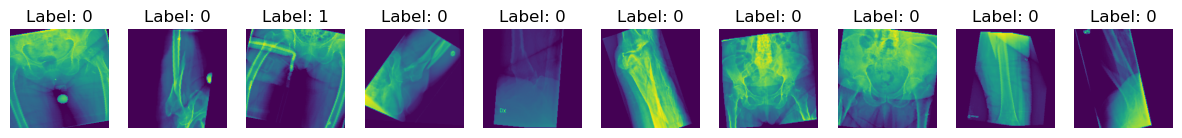

In [5]:
show_image(train_dataset, 10)


In [6]:
# resnet50
resnet50 = train_model(train_loader, val_loader,
                       classweight=classweight,
                       num_epochs=50, 
                       lr=0.001, step_size=10, gamma=0.1,
                       device=device,
                       model_name='resnet50')


Epoch 1/50, Train Loss: 0.2962, Validation Loss: 0.5124, Train Acc: 68.26%, Validation Acc: 83.13%
Epoch 2/50, Train Loss: 0.1936, Validation Loss: 0.3647, Train Acc: 79.32%, Validation Acc: 81.31%
Epoch 3/50, Train Loss: 0.1368, Validation Loss: 0.4090, Train Acc: 82.78%, Validation Acc: 89.75%
Epoch 4/50, Train Loss: 0.3221, Validation Loss: 0.3025, Train Acc: 84.34%, Validation Acc: 86.86%


KeyboardInterrupt: 

Test Loss: 0.1877, Test Acc: 93.64%
AUC: 0.9308975145302141
Confusion Matrix:
[[319  20]
 [  8  93]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.98      0.94      0.96       339
         AFF       0.82      0.92      0.87       101

    accuracy                           0.94       440
   macro avg       0.90      0.93      0.91       440
weighted avg       0.94      0.94      0.94       440



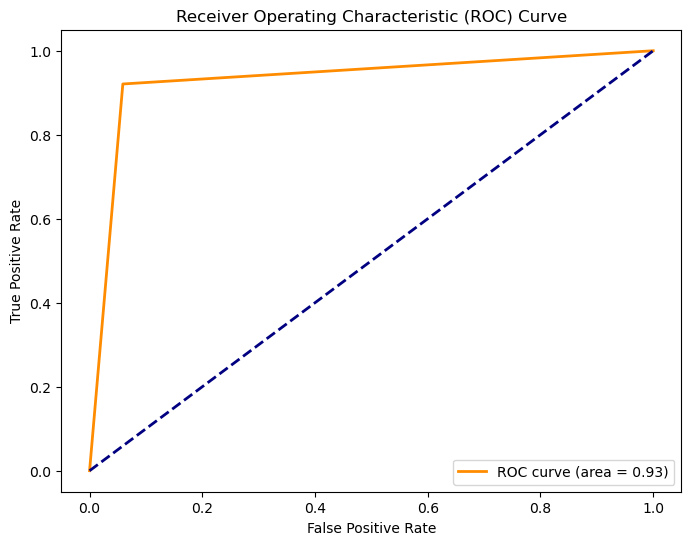

In [ ]:
test_model(model=resnet50, test_dataset=test_dataset, batch_size=batch_size, device=device)


Epoch 1/50, Train Loss: 0.7779, Validation Loss: 0.5569, Train Acc: 63.53%, Validation Acc: 77.14%
Epoch 2/50, Train Loss: 0.4392, Validation Loss: 0.4268, Train Acc: 78.19%, Validation Acc: 81.54%
Epoch 3/50, Train Loss: 0.3628, Validation Loss: 0.3452, Train Acc: 86.17%, Validation Acc: 85.60%
Epoch 4/50, Train Loss: 0.2172, Validation Loss: 0.2779, Train Acc: 89.25%, Validation Acc: 87.14%
Epoch 5/50, Train Loss: 0.2028, Validation Loss: 0.2036, Train Acc: 91.88%, Validation Acc: 91.32%
Epoch 6/50, Train Loss: 0.3179, Validation Loss: 0.2535, Train Acc: 91.32%, Validation Acc: 89.45%
Epoch 7/50, Train Loss: 0.2098, Validation Loss: 0.1767, Train Acc: 92.92%, Validation Acc: 92.64%
Epoch 8/50, Train Loss: 0.1629, Validation Loss: 0.1967, Train Acc: 93.92%, Validation Acc: 91.87%
Epoch 9/50, Train Loss: 0.2200, Validation Loss: 0.1930, Train Acc: 94.02%, Validation Acc: 92.09%
Epoch 10/50, Train Loss: 0.3716, Validation Loss: 0.1818, Train Acc: 95.46%, Validation Acc: 93.96%
Epoch 11/

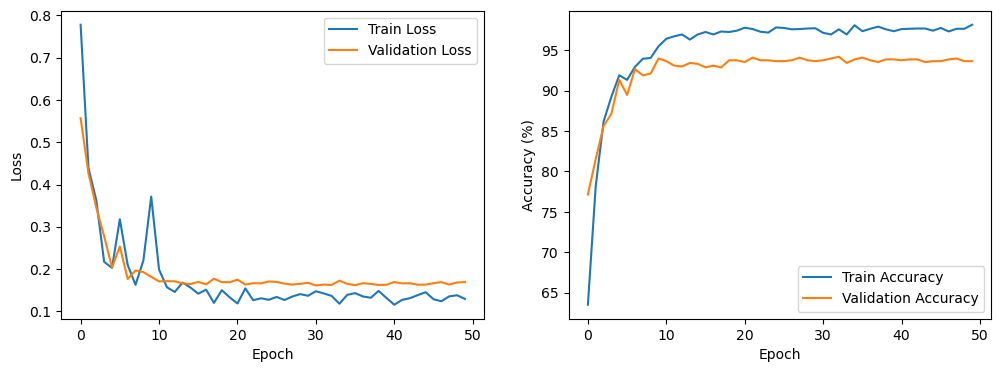

In [ ]:
# resnet101
resnet101 = train_model(train_loader, validation_loader, classweight, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet101', device=device)


Test Loss: 0.2661, Test Acc: 92.01%
AUC: 0.9342039545200811
Confusion Matrix:
[[306  31]
 [  4  97]]
Classification Report:
              precision    recall  f1-score   support

       0_NFF       0.99      0.91      0.95       337
       1_AFF       0.76      0.96      0.85       101

    accuracy                           0.92       438
   macro avg       0.87      0.93      0.90       438
weighted avg       0.93      0.92      0.92       438



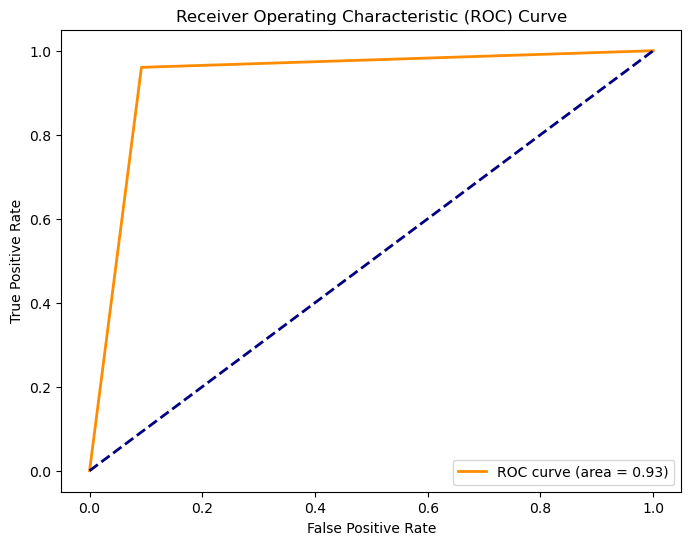

In [ ]:
test_model(model=resnet101, test_dataset=test_dataset, batch_size=batch_size, device=device)


Epoch 1/50, Train Loss: 0.7829, Validation Loss: 0.5185, Train Acc: 63.56%, Validation Acc: 81.54%
Epoch 2/50, Train Loss: 0.3153, Validation Loss: 0.3751, Train Acc: 80.66%, Validation Acc: 83.63%
Epoch 3/50, Train Loss: 0.4102, Validation Loss: 0.3024, Train Acc: 87.84%, Validation Acc: 89.01%
Epoch 4/50, Train Loss: 0.6802, Validation Loss: 0.2732, Train Acc: 91.02%, Validation Acc: 90.11%
Epoch 5/50, Train Loss: 0.3443, Validation Loss: 0.2618, Train Acc: 91.78%, Validation Acc: 89.23%
Epoch 6/50, Train Loss: 0.2710, Validation Loss: 0.2747, Train Acc: 93.29%, Validation Acc: 88.57%
Epoch 7/50, Train Loss: 0.7012, Validation Loss: 0.2161, Train Acc: 93.62%, Validation Acc: 91.87%
Epoch 8/50, Train Loss: 0.5788, Validation Loss: 0.2179, Train Acc: 95.26%, Validation Acc: 93.52%
Epoch 9/50, Train Loss: 0.1463, Validation Loss: 0.3037, Train Acc: 95.52%, Validation Acc: 87.91%
Epoch 10/50, Train Loss: 0.2190, Validation Loss: 0.2188, Train Acc: 96.16%, Validation Acc: 92.31%
Epoch 11/

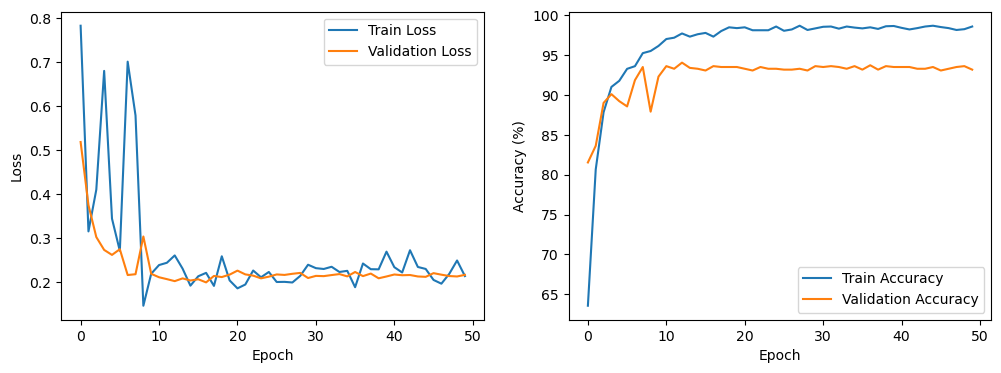

In [ ]:
# resnet152
resnet152 = train_model(train_loader, validation_loader, classweight, 
                        num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet152', device=device)


Test Loss: 0.2897, Test Acc: 92.24%
AUC: 0.9252871874724564
Confusion Matrix:
[[310  27]
 [  7  94]]
Classification Report:
              precision    recall  f1-score   support

       0_NFF       0.98      0.92      0.95       337
       1_AFF       0.78      0.93      0.85       101

    accuracy                           0.92       438
   macro avg       0.88      0.93      0.90       438
weighted avg       0.93      0.92      0.92       438



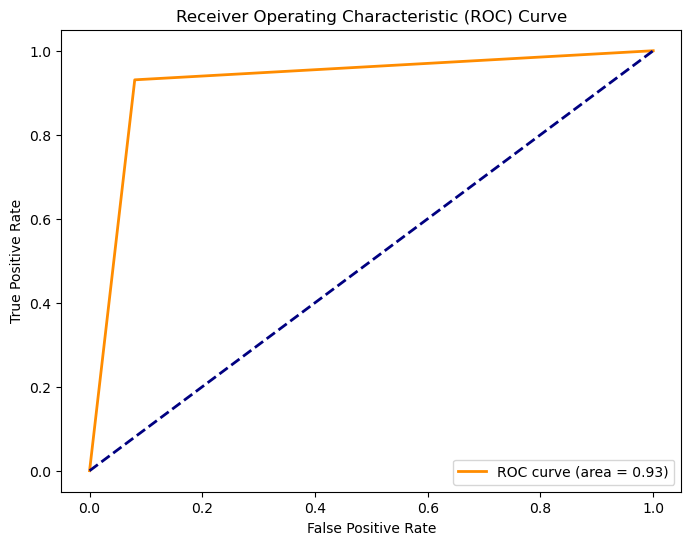

In [ ]:
test_model(model=resnet152, test_dataset=test_dataset, batch_size=batch_size, device=device)

Epoch 1/50, Train Loss: 0.3209, Validation Loss: 0.5070, Train Acc: 73.61%, Validation Acc: 76.70%
Epoch 2/50, Train Loss: 0.3237, Validation Loss: 0.3201, Train Acc: 86.87%, Validation Acc: 86.48%
Epoch 3/50, Train Loss: 0.1550, Validation Loss: 0.1959, Train Acc: 89.98%, Validation Acc: 91.98%
Epoch 4/50, Train Loss: 0.0629, Validation Loss: 0.2028, Train Acc: 91.98%, Validation Acc: 91.98%
Epoch 5/50, Train Loss: 0.2331, Validation Loss: 0.2506, Train Acc: 93.45%, Validation Acc: 89.78%
Epoch 6/50, Train Loss: 0.1157, Validation Loss: 0.1800, Train Acc: 93.15%, Validation Acc: 92.42%
Epoch 7/50, Train Loss: 0.1031, Validation Loss: 0.2040, Train Acc: 94.82%, Validation Acc: 91.32%
Epoch 8/50, Train Loss: 0.1948, Validation Loss: 0.2364, Train Acc: 95.29%, Validation Acc: 91.21%
Epoch 9/50, Train Loss: 0.0092, Validation Loss: 0.1751, Train Acc: 94.59%, Validation Acc: 94.07%
Epoch 10/50, Train Loss: 0.0212, Validation Loss: 0.1828, Train Acc: 96.39%, Validation Acc: 93.74%
Epoch 11/

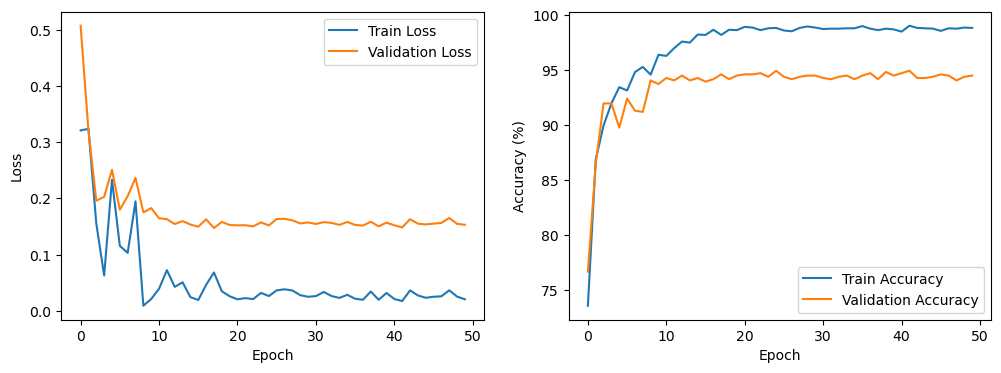

TypeError: test_model() missing 1 required positional argument: 'batch_size'

In [ ]:
# densenet161
densenet161 = train_model(train_loader, validation_loader, classweight, 
                          num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='densenet161', device=device)


In [ ]:
test_model(model=densenet161, test_dataset=test_dataset, batch_size=batch_size, device=device)

NameError: name 'densenet161' is not defined